#Лабораторная работа №4. Метод опорных векторов (Support-Vector Machine)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, cohen_kappa_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

**Задача страхового скоринга.**
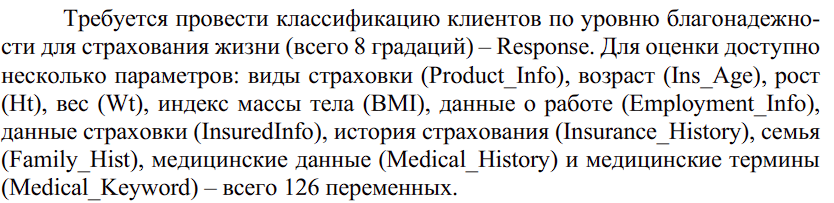

Построить модель опорных векторов (SVM) для наиболее оптимального разделения на классы, используется несколько реализаций: линейная (LinearSVC) и через градиентный бустинг (SGDClassifier).

In [ ]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [ ]:
data.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,...,0.056954,0.010054,0.045536,0.010710,0.007528,0.013691,0.008488,0.019905,0.054496,5.636837
std,22815.883089,0.160191,5.072885,0.282562,0.083107,0.739103,0.291949,0.197190,0.074239,0.089037,...,0.231757,0.099764,0.208479,0.102937,0.086436,0.116207,0.091737,0.139676,0.226995,2.456833
min,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19780.000000,1.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,39487.000000,1.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,59211.000000,1.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,79146.000000,2.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [ ]:
data.head().T

,0,1,2,3,4
Id,2,5,6,7,8
Product_Info_1,1,1,1,1,1
Product_Info_2,D3,A1,E1,D4,D2
Product_Info_3,10,26,26,10,26
Product_Info_4,0.076923,0.076923,0.076923,0.487179,0.230769
...,...,...,...,...,...
Medical_Keyword_45,0,0,0,0,0
Medical_Keyword_46,0,0,0,0,0
Medical_Keyword_47,0,0,0,0,0
Medical_Keyword_48,0,0,0,0,0


#Предобработка данных

In [ ]:
data['Product_Info_2_1'] = data['Product_Info_2'].str.slice(0,1)
data['Product_Info_2_2'] = pd.to_numeric(data['Product_Info_2'].str.slice(1,2))
data.drop(labels=['Product_Info_2'], axis=1, inplace=True)
for l in data['Product_Info_2_1'].unique():
  data['Product_Info_2_1' + l] = data['Product_Info_2_1'].isin([l]).astype('int8')
data.drop(labels=['Product_Info_2_1'], axis=1,inplace=True)
data.fillna(value=-1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 133 entries, Id to Product_Info_2_1B
dtypes: float64(18), int64(110), int8(5)
memory usage: 58.3 MB


Номер столбцов для расчета

In [ ]:
columns_groups = ['Insurance_History', 'InsuredInfo', 'Medical_Keyword','Family_Hist',
                  'Medical_History','Product_Info']
columns = ['Wt', 'Ht', 'Ins_Age', 'BMI']
for cg in columns_groups:
  columns.extend(data.columns[data.columns.str.startswith(cg)])
print(columns)

['Wt', 'Ht', 'Ins_Age', 'BMI', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4', 'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8', 'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12', 'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16', 'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20', 'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25', 'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29', 'Medical_Keyword_30', 'Medical_Keywor

#Нормализация данных

In [ ]:
scaler=preprocessing.StandardScaler()
data_transformed=pd.DataFrame(scaler.fit_transform(pd.DataFrame(data, columns=columns)))
columns_transformed=data_transformed.columns
data_transformed['Response'] = data['Response']

#Оптимизация памяти

In [ ]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
    col_type = df[col].dtypes
    if str(col_type)[:5] == 'float':
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min>np.finfo('f2').min and c_max < np.finfo('f2').max:
        df[col]=df[col].astype(np.float16)
      elif c_min>np.finfo('f4').min and c_max < np.finfo('f4').max:
        df[col]=df[col].astype(np.float32)
      else:
        df[col]=df[col].astype(np.float64)
    elif str(col_type)[:3] == 'int':
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min>np.iinfo('i1').min and c_max < np.iinfo('i1').max:
        df[col]=df[col].astype(np.int8)
      elif c_min>np.iinfo('i2').min and c_max < np.iinfo('i2').max:
        df[col]=df[col].astype(np.int16)
      elif c_min>np.iinfo('i4').min and c_max < np.iinfo('i4').max:
        df[col]=df[col].astype(np.int32)
      elif c_min>np.iinfo('i8').min and c_max < np.iinfo('i8').max:
        df[col]=df[col].astype(np.int64)
    elif col == 'timestamp':
      df[col]=pd.to_datetime(df[col])
    elif str(col_type)[:8] != 'datetime':
      df[col]=df[col].astype('category')
  end_mem=df.memory_usage().sum() /1024**2
  print('Потребление памяти на', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
  return df

In [ ]:
data_transformed = reduce_mem_usage(data_transformed)
print(data_transformed.info())

Потребление памяти на 42.87 Мб (минус 75.1 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 126 entries, 0 to Response
dtypes: float16(125), int8(1)
memory usage: 14.2 MB
None


#Разделение данных

In [ ]:
data_train, data_test = train_test_split(data_transformed, test_size=0.2)
data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,Response
34217,0.614258,1.249023,-0.770020,-0.020615,0.611816,-0.169434,0.862305,-1.013672,0.874512,-0.928711,...,-0.083679,0.441650,-0.149292,-0.200073,0.750977,-0.623535,-0.215942,-0.128906,-0.14209,7
37312,-0.278564,0.514160,1.046875,-0.610352,-1.634766,-0.169434,0.862305,0.043671,0.863281,-0.928711,...,-0.083679,0.441650,-0.149292,-0.200073,0.750977,-0.623535,-0.215942,-0.128906,-0.14209,7
35164,0.661133,-0.465576,1.727539,1.226562,-1.634766,-0.169434,0.862305,0.043671,0.862305,-0.928711,...,-0.083679,0.441650,-0.149292,-1.133789,0.750977,-0.623535,-0.215942,-0.128906,-0.14209,7
23027,0.355713,0.269287,1.273438,0.298340,-1.634766,-0.169434,0.862305,-1.013672,0.865723,-0.928711,...,-0.083679,-2.263672,-0.149292,-0.666992,0.750977,-0.623535,-0.215942,-0.128906,-0.14209,7
39935,-0.395996,-1.690430,-0.997070,0.701172,0.611816,-0.169434,-1.159180,1.100586,-1.156250,1.130859,...,-0.083679,0.441650,-0.149292,-1.133789,0.750977,-0.623535,-0.215942,-0.128906,-0.14209,2


#SVM
Выбираем направления преобразований исходных данных, чтобы различные классы можно было разделить гиперплоскостью по значениям параметров.

In [ ]:
x=pd.DataFrame(data_train, columns=columns_transformed)
model_lin=LinearSVC(max_iter=10000)
model_lin.fit(x, data_train['Response'])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000)

In [ ]:
model_sgd=SGDClassifier()
model_sgd.fit(x, data_train['Response'])

SGDClassifier()

#Предсказание данных и оценка модели

In [ ]:
x_test = pd.DataFrame(data_test, columns=columns_transformed)
data_test['target_lin'] = model_lin.predict(x_test)
data_test['target_sgd'] = model_sgd.predict(x_test)

In [ ]:
print('SVM (линейный: )', round(cohen_kappa_score(data_test['target_lin'],data_test['Response'], weights='quadratic'), 3))
print('SVM (градиент: )', round(cohen_kappa_score(data_test['target_sgd'],data_test['Response'], weights='quadratic'), 3))

SVM (линейный: ) 0.484
SVM (градиент: ) 0.464


In [ ]:
print (f1_score(data_test['target_lin'],data_test['Response'], average='weighted'))
print (f1_score(data_test['target_sgd'],data_test['Response'], average='weighted'))

0.539428570075203
0.49013424960032154


Матрица неточностей

In [ ]:
print ('SVM (линейный: )\n', confusion_matrix(data_test['target_lin'], data_test['Response']))
print ('SVM (градиент: )\n', confusion_matrix(data_test['target_sgd'], data_test['Response']))

SVM (линейный: )
 [[ 266  164   10    5   61  140   47   24]
 [ 201  288    8    1  124  138   33   20]
 [   0    0    0    0    0    0    0    0]
 [   7    3    7   20    1   10    0    3]
 [  73  168   13    0  267   85   21    8]
 [ 234  278  129  162  263  854  200  191]
 [ 111  100    1    2  106  252  437   36]
 [ 286  299   14   73  268  708  919 3738]]
SVM (градиент: )
 [[ 262  204   21   18  123  215  100   54]
 [ 236  329   20   13  135  244  123   52]
 [   9    9    4   16    4   12    0    2]
 [  18   16   13   44    8   56    9   17]
 [  85  155   23   11  222  163  102   49]
 [ 201  231   76   79  266  644  244  170]
 [ 120  100    7   11   87  249  280   92]
 [ 247  256   18   71  245  604  799 3584]]
